In [1]:
%load_ext autoreload
%autoreload 2
from predictive_models import IHE_Model, Poor_Outcome_Model
from bootstrapping_ci import *
import pandas as pd
from subsets import *
from tqdm.notebook import tqdm
import json
import pickle
from generate_figures import *

# Andexanet Alfa Simulation Study
Andexanet alfa (Andexxa) is a biological decoy that has been approved for the acute reversal of FXa inhibitors in FXa inhibitor associated intracerebral hemorrhage (ICH) following the results of the ANNEXA-4 study (1). However, with the study being single-arm, the impact of its use in FXa inhibitor-associated ICH is unknown. Here, we present a simulation study where the effects of the drug can be estimated on own institutional data.


<b>References</b>
1. Connolly SJ, Crowther M, Eikelboom JW, et al. Full Study Report of Andexanet Alfa for Bleeding Associated with Factor Xa Inhibitors. New England Journal of Medicine. 2019;380(14):1326-1335. doi:10.1056/NEJMoa1814051

### Load Data and feature dictionary

In [2]:
feature_dictionary = json.load(open("variable_names.json", mode="r"))
dataset = pd.read_csv("./Datasets/synthetic_data.csv")

### Generate subsets of the data
ANNEXA-4-Comparable Cohort
* Emulates the inclusion criteria of the ANNEXA-4 study. Removes patients with an initial ICH volume larger than 60cc, initial GCS 3-4, time between last known well and first head CT greater than 18 hours, and WLST on admission

ANNEXA-4-Ineligible Cohort
* All patients who were not eligible for the ANNEXA-4 study

Higher Likelihood of Favorable Outcome in the ANNEXA-4 Cohort
* patients with an initial GCS 13-15
* patients who survived hospitalization without WLST status

Real-World FXa inhibitor use
* patients who were using FXa inhibitors in real life

ANNEXA-4-Ineligible because of high ICH volume and low GCS
* patients who had initial ICH volumes larger than 60cc and GCS scores between 3-4

In [3]:
subsets = [
    dataset,
    get_ANNEXA4_comparable_cohort(dataset, feature_dictionary),
    get_ANNEXA4_ineligible_cohort(dataset, feature_dictionary),
    get_higher_likelihood_of_favorable_outcome_in_ANNEXA4_cohort(dataset, feature_dictionary),
    get_FXai_df(dataset, feature_dictionary),
    get_high_ICH_volume_low_GCS_cohort(dataset, feature_dictionary),
    ]

subset_names = [
    "Full Cohort",
    "ANNEXA-4-Comparable",
    "ANNEXA-4-Ineligible",
    "Higher likelihood of Favorable Outcome",
    "Real-World FXai use",
    "ANNEXA-4-Ineligible because of high ICH volume and low GCS"
]

Generating the ANNEXA-4-comparable Cohort...
	Initial ICH Volume >60cc: 51 removed
	Initial GCS 3-4: 30 removed
	Time between LKW and first head CT >18 hrs: 196 removed
	CMO/WLST status at admission: 21 removed
	Length before Exclusion: 700
	Length after Exclusion: 402

Getting patients with a higher likelihood of a favorable functional outcome
among the ANNEXA-4 comparable cohort...
	CMO/WLST status at any time in hospital stay: 97 removed
	Discharged to Hospice: 36 removed
	Dead at Discharge (mRS = 6): 0 removed
	Initial GCS Score not 13-15: 81 removed



### Simulate the Andexanet Effects
First a predictive logistic regression model is created to determine the probability for developing inadequate hemostasis (IH), defined as an 35% increate in initial ICH volume. Then a predictive logistic regression model is created to determine the probability for unfavorable clinical outcome, defined as mRS 4-6 in 3 months following discharge. The IH model uses known clinical predictors for hematoma expansion, while the outcome model uses known predictors for clinical outcome as well as the probability for IH returned by the IH model.

Before analysis, FXa inhibitor use is simulated in all patients. Afterwards, andexanet effects are simulated by reducing the returned IH probability score, and subsequent outcome due to andexanet are modeled by inputting the reduced probability into the outcome model. 

In [4]:
simulation_run = simulate_andexanet_effects(
                            n_bootstrapped_samples = 1000,
                            training_ihe_dataset = dataset,
                            training_outcome_dataset = dataset,
                            simulation_based_cohorts = subsets,
                            simulation_based_cohort_names = subset_names,
                            feature_dictionary = feature_dictionary,
                            generate_CI_by_using_bootstrapped_models_in_simulation = True,
                            random_state = 0,
                            parallel = True
                            )

2021-07-23 00:35:40,995:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': 0}")


SUBMITTING | :   0%|          | 0/1000 [00:00<?, ?it/s]

PROCESSING | :   0%|          | 0/1000 [00:00<?, ?it/s]

COLLECTING | :   0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
#save the run as it can take a long time to generate each time
pickle.dump(simulation_run, open("./saved_runs/simulation_results.pkl", "wb"))

### Get the results of the run

In [9]:
simulation_run.get_metrics()

IHE Model


,Feature,Column,Coef,OR,Lower 95% CI OR,Upper 95% CI OR
0,Log-transformed initial ICH volume,log_ich_volume,-0.042,0.959,0.818,1.123
1,Log-transformed hours from LKW to hospital arr...,log_lkw_hct1,-0.127,0.881,0.748,1.044
2,Warfarin Use,anticoag_home___1,-0.248,0.780,0.296,1.887
3,FXa inhibitor use,xa_inhib,0.141,1.152,0.333,2.408
4,CTA spot sign,ich_spotsign,-0.366,0.694,0.091,1.436
5,Other Coagulopathy,other_coag,-0.662,0.516,0.105,2.413
6,Single Antiplatelet,one_antiplatelet_use,0.206,1.229,0.566,1.975
7,Double Antiplatelet,two_antiplatelet_use,-1.110,0.330,0.089,1.028
8,Systolic BP on Arrival,arrival_sbp,0.001,1.001,0.995,1.006
9,Cons,Cons,0.209,1.233,0.491,3.480



Outcome Model


,Feature,Column,Coef,OR,Lower 95% CI OR,Upper 95% CI OR
0,Log-transformed Age,log_age,0.229,1.258,0.736,2.210
1,Log-transformed initial ICH volume,log_ich_volume,-0.003,0.997,0.925,1.066
2,Initial GCS Score: 5-12,gcs_initial1,-0.224,0.800,0.564,1.129
3,Initial GCS Score: 3-4,gcs_initial2,-0.210,0.811,0.448,1.528
4,IVH,ivh,-0.160,0.852,0.632,1.126
5,Probability for IHE,ihe_probability,0.639,1.894,0.474,4.701
6,Cons,Cons,-1.040,0.353,0.032,3.850


Full Cohort (n= 700)
	Mean Outcome Prob w/o additional treatment effect: 53.1% (95% CI: 48.1%-58.3%)
	ARR at 33% IHE probability reduction: 2.8% (95% CI: -2.6%-7.1%)
	ARR at 50% IHE probability reduction: 4.2% (95% CI: -3.9%-10.7%)
	NNT at 33%: 36
	NNT at 50%: 24
	Cum cost at 33%: $891000
	Cum cost at 50%: $594000
ANNEXA-4-Comparable (n= 402)
	Mean Outcome Prob w/o additional treatment effect: 53.7% (95% CI: 48.6%-59.3%)
	ARR at 33% IHE probability reduction: 3.0% (95% CI: -2.7%-7.6%)
	ARR at 50% IHE probability reduction: 4.5% (95% CI: -4.1%-11.5%)
	NNT at 33%: 34
	NNT at 50%: 23
	Cum cost at 33%: $841500
	Cum cost at 50%: $569250
ANNEXA-4-Ineligible (n= 298)
	Mean Outcome Prob w/o additional treatment effect: 52.4% (95% CI: 47.0%-57.9%)
	ARR at 33% IHE probability reduction: 2.6% (95% CI: -2.4%-6.6%)
	ARR at 50% IHE probability reduction: 3.9% (95% CI: -3.7%-10.0%)
	NNT at 33%: 39
	NNT at 50%: 26
	Cum cost at 33%: $965250
	Cum cost at 50%: $643500
Higher likelihood of Favorable Outco

### Get plots of the results

Getting the ANNEXA-4-Comparable
Getting the ANNEXA-4-Ineligible because of high ICH volume and low GCS


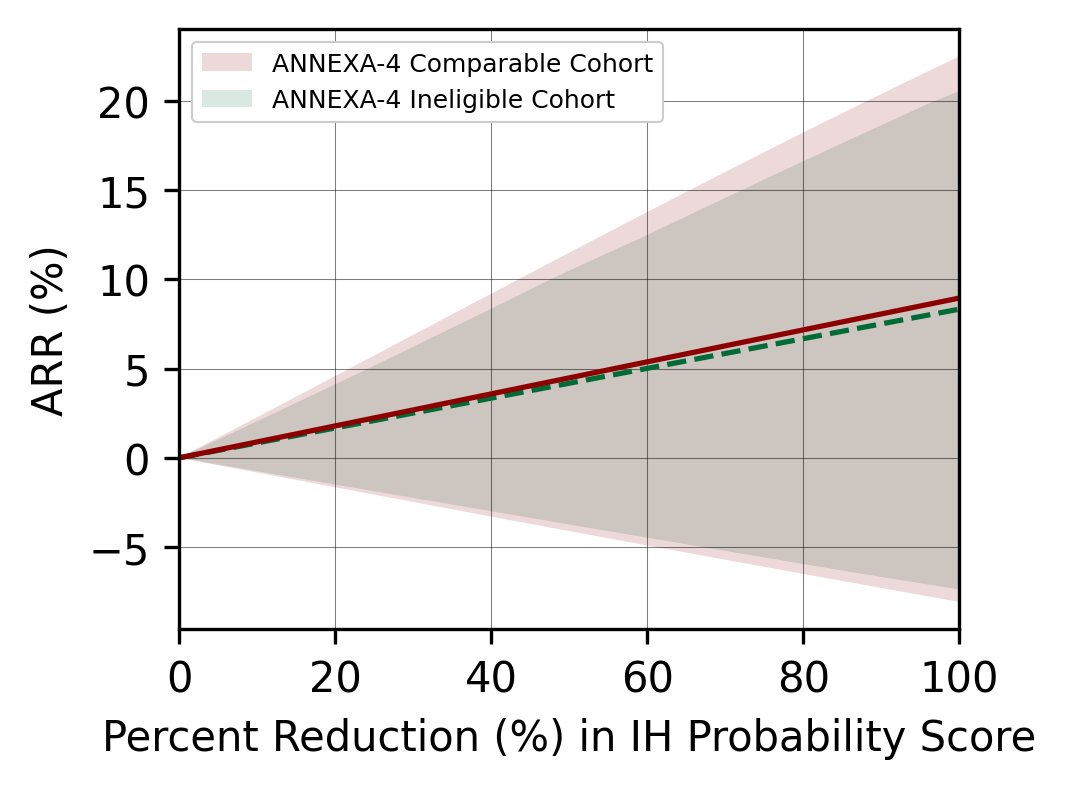

In [10]:
#plot the ARRs
annexa_4_subset_ix = 1
exclusion_subset_ix = 5
print("Getting the", simulation_run.simulation_based_cohort_names[annexa_4_subset_ix])
print("Getting the", simulation_run.simulation_based_cohort_names[exclusion_subset_ix])

arr_annexa = simulation_run.original_data_dict["ARR"][annexa_4_subset_ix]
arr_exclusion = simulation_run.original_data_dict["ARR"][exclusion_subset_ix]
arr_annexa_bs = simulation_run.bootstrapped_data_dict["ARR"][annexa_4_subset_ix]
arr_exclusion_bs = simulation_run.bootstrapped_data_dict["ARR"][exclusion_subset_ix]

get_ARR_plots([arr_annexa, arr_exclusion],
              [arr_annexa_bs, arr_exclusion_bs], 
              ["ANNEXA-4 Comparable Cohort", "ANNEXA-4 Ineligible Cohort"],
              (3.25, 2.5),
              300,
              None
             )

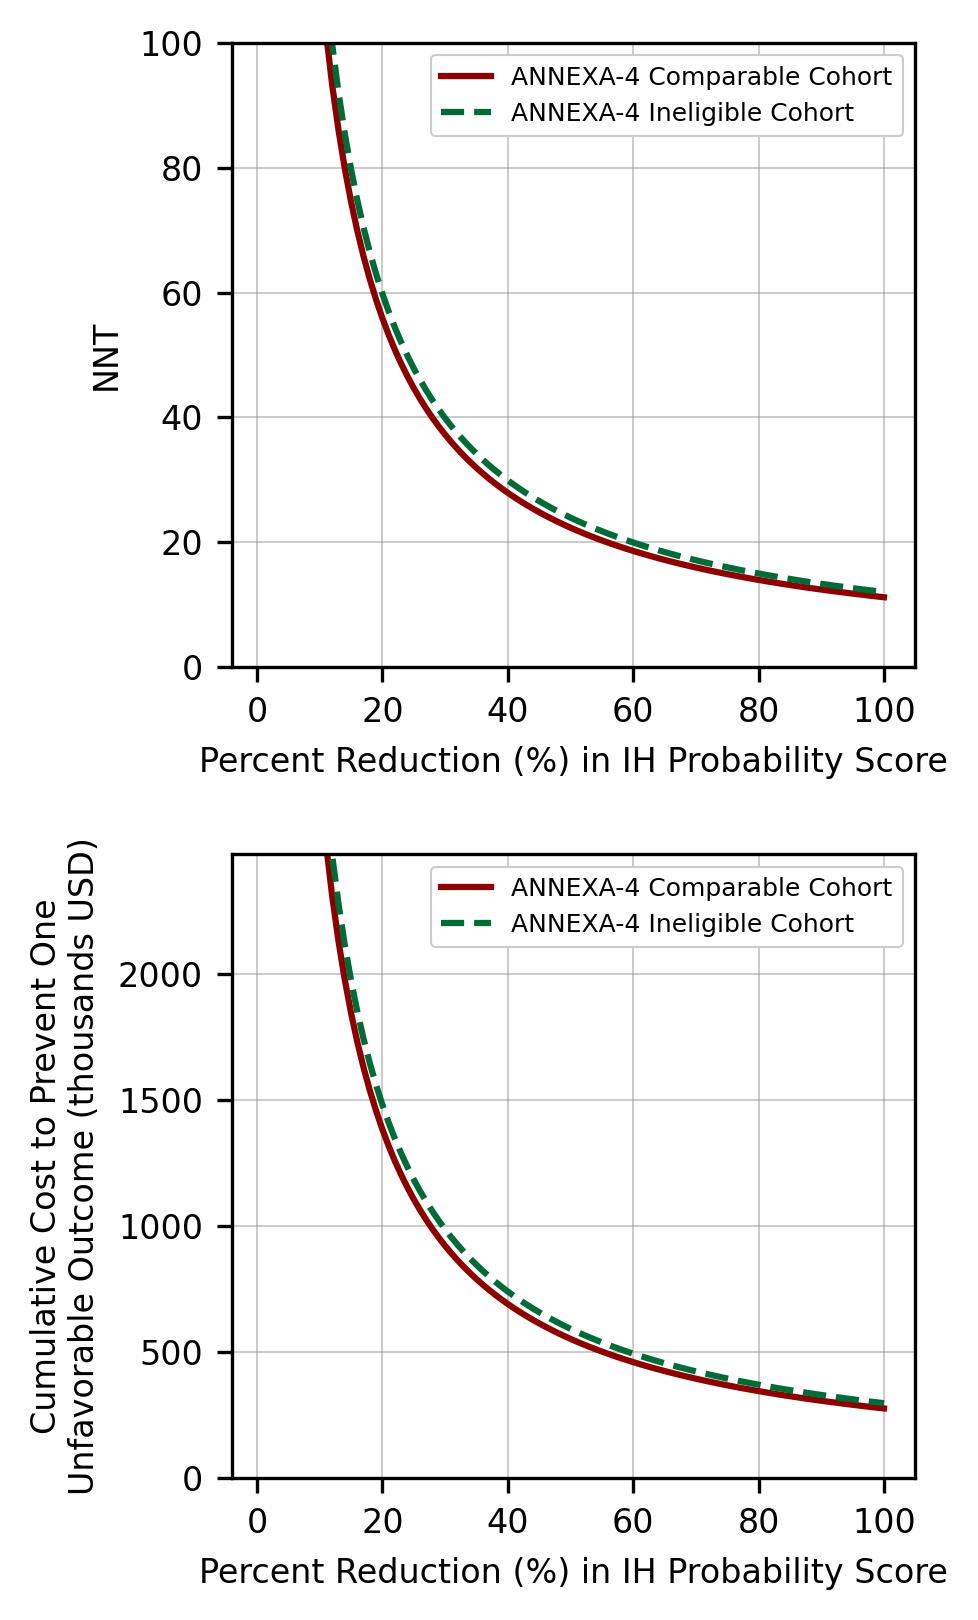

In [11]:
nnt_annexa = simulation_run.original_data_dict["NNT"][annexa_4_subset_ix]
nnt_exclusion = simulation_run.original_data_dict["NNT"][exclusion_subset_ix]

get_NNT_cost_plots(
    [nnt_annexa, nnt_exclusion],
    ["ANNEXA-4 Comparable Cohort", "ANNEXA-4 Ineligible Cohort"],
    (3.25, 5.5),
    300,
    feature_dictionary,
    None
)